# Digit Recgnition

This notebook demonstrates use of MLP and K-means algorithm to recognise digits of the MNIST dataset.

## 1.1. Simple K-means
Import training data from local storage:

In [1]:
import struct
import numpy as np

def loadMNIST( prefix, folder ):
    intType = np.dtype('int32').newbyteorder( '>' )
    nMetaDataBytes = 4 * intType.itemsize

    data = np.fromfile( folder + "/" + prefix + '-images.idx3-ubyte', dtype = 'ubyte' )
    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )
    data = data[nMetaDataBytes:].astype( dtype = 'float32' ).reshape( [ nImages, width, height ] )

    _labels = np.fromfile( folder + "/" + prefix + '-labels.idx1-ubyte',
                          dtype = 'ubyte' )[2 * intType.itemsize:]
    print(_labels.shape)
    print(data.shape)
    return data, _labels

data, labels = loadMNIST( "train", "train" )
test_data, test_labels = loadMNIST( "t10k", "test" )

(60000,)
(60000, 28, 28)
(10000,)
(10000, 28, 28)


Then we convert the labels to One-Hot Encoding, where it simulates the output of an MLP's last layer.

In [2]:
def toHotEncoding( classification ):
    
    hotEncoding = np.zeros( [ len( classification ), 
                              np.max( classification ) + 1 ] )
    hotEncoding[ np.arange( len( hotEncoding ) ), classification ] = 1
    return hotEncoding

hlabels = toHotEncoding( labels )
htest_labels = toHotEncoding( test_labels )

To check the import process, we can plot 9 sample datapoints using matplotlib, and print their labels.

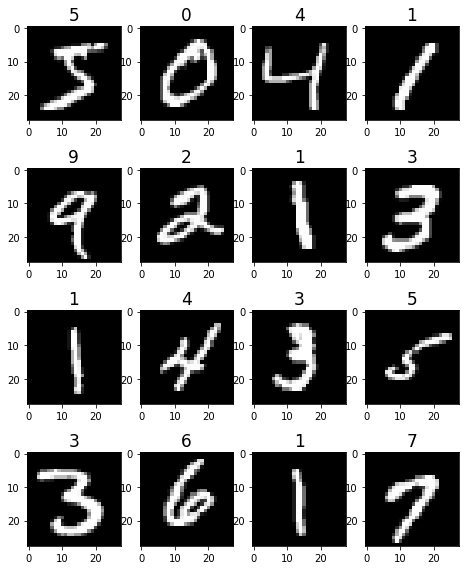

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))

for i in range(16):
    plt.subplots_adjust(0.3)
    plt.subplot(4,4,i+1)
    plt.title(labels[i],fontsize = 17)
    plt.imshow(data[i])

Converting the data to float will allow for normalization, i.e. setting minimum to 0 and maximum value to 1.

In [6]:
data = data.astype('float32') 
test_data = test_data.astype('float32')

data = data/255.0
test_data = test_data/255.0

We need to reshape the data from 3 dimensions to two. Afterwards, instead of 28x28 images, we will have all data in one 784 array.

In [7]:
Data = data.reshape(len(data),-1)
Test_data = test_data.reshape(len(test_data),-1)

In [6]:
from sklearn.cluster import MiniBatchKMeans
k_value = len(np.unique(labels))
kmeans = MiniBatchKMeans(n_clusters = k_value)
kmeans.fit(Data)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

A function to label clusters based on their most frquent digit (the default labels that `kmeans.labels_` gives is just a number depending on the method and does not represent the actual data.

Note that with 10 clusters, some digits may not even be assigned a cluster. This will be discussed in next section.

In [31]:
def retrieve_labels(cluster_labels,labels):
    ref_labels = {}
    for i in range(len(np.unique(kmeans.labels_))):
        idx = np.where(cluster_labels == i,1,0)
        num = np.bincount(labels[idx==1]).argmax()
        ref_labels[i] = num
    print(ref_labels)
    return ref_labels

In [32]:
ref_labels = retrieve_labels(kmeans.labels_,labels)
number_labels = np.zeros(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = ref_labels[kmeans.labels_[i]]

{0: 8, 1: 6, 2: 0, 3: 6, 4: 1, 5: 7, 6: 3, 7: 4, 8: 7, 9: 2}


In [33]:
from sklearn.metrics import accuracy_score
print("predicted labels:\t", number_labels[:16].astype('int'))
print("true labels:\t\t",labels[:16])
print('---------------------------------------------------')
print("Accuracy:" , accuracy_score(number_labels,labels))

predicted labels:	 [8 0 4 1 7 2 1 8 1 7 3 1 3 6 1 7]
true labels:		 [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7]
---------------------------------------------------
Accuracy: 0.5853666666666667


## 1.2. K-Means Optimisation

The basic form of K-means gives us a mediocre accuracy of ~0.54, to improve, we attempt to see the performance for various values of `k > 10`. In this way, digits of the same label but with differing properties may be clustered better if allowed to 'split'.

To compare, we need new metrics: _inertia_ and _homogeneity_. 
Inertia computes the coherency of the clusters, inversely porportional to the sum of squares of the distances from their centroids. This means the larger `k` gives smaller inertia, since clusters reduce in size. Homogeneity is how likely is that points belong to a single cluster (if we assume there's a likelihood points can belong to more than one cluster). 
Rand Index is also computed, but as the cluster number increases, it means that False Negatives increase, and hence is not a good performance measure.
Lastly, accuracy score is computed, which we observe to increase with the value of `k`.

In [29]:
from sklearn import metrics

def get_metrics(model,output):
    print('Number of clusters: {}'.format(model.n_clusters))
    print('Inertia : {:.2f}'.format(model.inertia_))
    print('Homogeneity : {:.5f}'.format(metrics.homogeneity_score(output, model.labels_)))
    print('Rand Index: {:.5f}'.format(metrics.adjusted_rand_score(output, model.labels_)))
    print('NMI: {:.5f}'.format(metrics.v_measure_score(output, model.labels_)))

The following results for various values of `k` show that up to some point, a higher `k` gives more desirable output with higher accuracy, even though Rand Index is reduced. However, note that accuracy always grows, hence we use NMI (`v_measure_score`) to take the number of clusters into account, as well. This gives us the most desirable point in `k` = 32.

In [33]:
k_values = [10, 16, 32, 64, 128, 256]
for k in k_values:
    true_clusters = len(np.unique(test_labels))
    kmeans = MiniBatchKMeans(n_clusters = k)
    kmeans.fit(Data)
    get_metrics(kmeans, labels)
    ref_labels = retrieve_labels(kmeans.labels_,labels)
    number_labels = np.random.rand(len(kmeans.labels_))
    for i in range(len(kmeans.labels_)):
         number_labels[i] = ref_labels[kmeans.labels_[i]]
    print('Accuracy (Purity): {:.5f}'.format(metrics.accuracy_score(number_labels,labels)))
    print("------------------------\n")


Number of clusters: 10
Inertia : 2440656.50
Homogeneity : 0.41852
Rand Index: 0.29734
NMI: 0.42761
Accuracy (Purity): 0.51528
------------------------

Number of clusters: 16
Inertia : 2218428.50
Homogeneity : 0.56846
Rand Index: 0.36605
NMI: 0.52084
Accuracy (Purity): 0.68178
------------------------

Number of clusters: 32
Inertia : 2097759.00
Homogeneity : 0.63157
Rand Index: 0.30305
NMI: 0.51656
Accuracy (Purity): 0.71708
------------------------

Number of clusters: 64
Inertia : 1812878.12
Homogeneity : 0.73931
Rand Index: 0.19337
NMI: 0.53150
Accuracy (Purity): 0.80803
------------------------

Number of clusters: 128
Inertia : 1656539.38
Homogeneity : 0.79835
Rand Index: 0.11552
NMI: 0.51956
Accuracy (Purity): 0.86767
------------------------

Number of clusters: 256
Inertia : 1514567.50
Homogeneity : 0.84159
Rand Index: 0.06418
NMI: 0.49845
Accuracy (Purity): 0.89863
------------------------



To test the results, we will now fit the model for the test data, and compare its accuracy with the one given above. This gives us an accuracy score is quite close to the training accuracy, hence the model has not been overfitted.

In [37]:
k_value = 64
kmeans = MiniBatchKMeans(n_clusters = k_value)
kmeans.fit(Test_data)
get_metrics(kmeans, test_labels)
ref_labels = retrieve_labels(kmeans.labels_,test_labels)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
     number_labels[i] = ref_labels[kmeans.labels_[i]]
print('Accuracy: {:.5f}'.format(metrics.accuracy_score(number_labels,test_labels)))

Number of clusters: 64
Inertia : 298502.41
Homogeneity : 0.75818
Rand Index: 0.20408
NMI: 0.54903
Accuracy: 0.82990


Now that we have an optimal `k` value, we can tweak the other parts of the algorithm.

In [59]:
k_value = 64
init_values = [1, 3, 5, 10]
for n in init_values:
    kmeans = MiniBatchKMeans(n_clusters = k_value, n_init = n)
    kmeans.fit(Data)
    print('Number of initialisations tried: {}'.format(n))
    get_metrics(kmeans, labels)
    ref_labels = retrieve_labels(kmeans.labels_,labels)
    number_labels = np.random.rand(len(kmeans.labels_))
    for i in range(len(kmeans.labels_)):
         number_labels[i] = ref_labels[kmeans.labels_[i]]
    print('Accuracy (Purity): {:.5f}'.format(metrics.accuracy_score(number_labels,labels)))
    print("------------------------\n")

Number of initialisations tried: 1
Number of clusters: 64
Inertia : 27.98
Homogeneity : 0.73178
Rand Index: 0.18580
NMI: 0.52595
Accuracy (Purity): 0.80595
------------------------

Number of initialisations tried: 3
Number of clusters: 64
Inertia : 27.98
Homogeneity : 0.74871
Rand Index: 0.20724
NMI: 0.54143
Accuracy (Purity): 0.82777
------------------------

Number of initialisations tried: 5
Number of clusters: 64
Inertia : 27.88
Homogeneity : 0.74995
Rand Index: 0.19488
NMI: 0.54060
Accuracy (Purity): 0.82633
------------------------

Number of initialisations tried: 10
Number of clusters: 64
Inertia : 27.90
Homogeneity : 0.74425
Rand Index: 0.19054
NMI: 0.53590
Accuracy (Purity): 0.81940
------------------------



Visualising this with an estimate of centroids on a 28×28 image will be useful to see the reason in the efficiency of using a larger `k` .
As seen in the results, same labels are associated with various styles of the same digit.

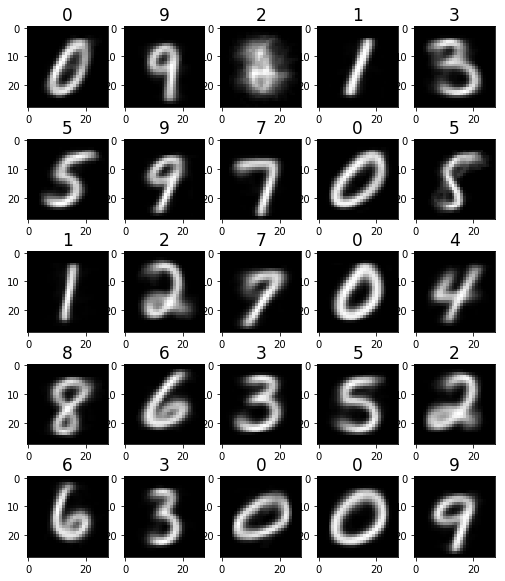

In [39]:
centroids = kmeans.cluster_centers_
centroids = centroids.reshape(k_value,28,28)
# eliminate normalisation done earlier
centroids = centroids * k_value

plt.figure(figsize = (10,10))
bottom = 0.25

for i in range(25):
    plt.subplots_adjust(bottom)
    plt.subplot(5,5,i+1)
    plt.title(ref_labels[i],fontsize = 17)
    plt.imshow(centroids[i])

In [11]:
from sklearn import neural_network as nn
from sklearn import metrics

mlp = nn.MLPClassifier(activation='logistic', learning_rate_init=0.001, verbose=True)
mlp.fit(Data, labels)
training_accuracy = metrics.accuracy_score(labels, mlp.predict(Data))
test_accuracy = metrics.accuracy_score(test_labels, mlp.predict(Test_data))
print("Training Accuracy: {:.5f}".format(training_accuracy))
print("Test Accuracy: {:.5f}".format(test_accuracy))

Iteration 1, loss = 0.85659529
Iteration 2, loss = 0.33347438
Iteration 3, loss = 0.26197039
Iteration 4, loss = 0.22346459
Iteration 5, loss = 0.19598134
Iteration 6, loss = 0.17465862
Iteration 7, loss = 0.15745660
Iteration 8, loss = 0.14295617
Iteration 9, loss = 0.13047510
Iteration 10, loss = 0.12025558
Iteration 11, loss = 0.11074744
Iteration 12, loss = 0.10235792
Iteration 13, loss = 0.09519932
Iteration 14, loss = 0.08838951
Iteration 15, loss = 0.08214042
Iteration 16, loss = 0.07662933
Iteration 17, loss = 0.07154167
Iteration 18, loss = 0.06694167
Iteration 19, loss = 0.06263163
Iteration 20, loss = 0.05849437
Iteration 21, loss = 0.05503837
Iteration 22, loss = 0.05151582
Iteration 23, loss = 0.04843155
Iteration 24, loss = 0.04531555
Iteration 25, loss = 0.04255455
Iteration 26, loss = 0.04002203
Iteration 27, loss = 0.03774678


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training Accuracy: 0.99405
Test Accuracy: 0.97620
